# 实验二：正则化实验

## 实验介绍

优化器是神经网络训练过程中非常重要的结构，正是因为优化器的存在帮助初始化参数的网络一步步学习到了符合训练集数据特征的最优参数。本实验主要介绍如何使用MindSpore进行优化实验。　

本实验主要基于Fashion Mnist数据集，分析正则化对模型过拟合、优化的作用及特点。

## 实验目的

- 掌握正则化对模型过拟合、优化的作用及特点，并通过MindSpore实现。

## 实验环境

- MindSpore 1.7.0

## 实验内容



### 实验原理

一般而言，样本特征由于来源以及度量单位不同，他们的尺度（Scale）往往差异很大。我们对于将全部或部分特征进行缩放后不影响其学习和预测的算法，称该算法具有尺寸不变性（Scale Invariance）。

对于特征尺度差异较大时，梯度下降法的效率也会受其影响，因此我们需对其进行数据归一化。

**Batch_Normalization**：批量归一化，是一种有效的逐层归一化方法，可以对神经网络中任意的中间层进行归一化操作。对于深度神经网络：

$$
a^{(l)} = f(z^{(l)}) = f(Wa^{(l-1)}+b)
$$

批量归一化，就是使得净输入$z^{(l)}$的分布一致。

机器学习模型的关键是泛化问题，即在样本真实分布上的期望风险最小化。而训练数据集上的经验风险最小化和期望风险并不一致。由于深度学习的拟合能力特别强，容易造成模型过拟合，因此如何提高神经网络的繁华能力反而成为影响模型能力的关键因素。

**Dropout**：丢弃法，当训练一个深度神经网络时，我们可以随机丢弃一部分神经元（同时丢弃其对应的连接边）来避免过拟合。

**L2**：在风险函数中直接加入正则项，通过约束L2番薯来减小模型在训练数据集上的过拟合问题。

$$
\theta ^*=\mathrm{arg}\!\:\min \!\:\frac{1}{N}\sum_{n=1}^N{\mathcal{L} \left( y^{\left( n \right)},f\left( x^{\left( n \right)};\theta \right) \right) +\lambda l_p(\theta )}
$$

**Early_Stop**：提前停止。我们使用一个与训练集独立的样本集合，成为验证集（Validation Set），并用验证集上的错误来代替期望错误，若测试集上错误率不再下降，就停止迭代。

In [1]:
%cd /home/ma-user/work

/home/ma-user/work


In [2]:
#从OBS桶下载数据集
!wget https://ascend-professional-construction-dataset.obs.myhuaweicloud.com/deep-learning/fashion-mnist.zip
#解压文件
!unzip fashion-mnist.zip
# 删除文件
!rm fashion-mnist.zip

--2025-12-13 18:27:38--  https://ascend-professional-construction-dataset.obs.myhuaweicloud.com/deep-learning/fashion-mnist.zip
Resolving ascend-professional-construction-dataset.obs.myhuaweicloud.com (ascend-professional-construction-dataset.obs.myhuaweicloud.com)... 100.125.76.5, 100.125.83.5, 100.125.83.133
Connecting to ascend-professional-construction-dataset.obs.myhuaweicloud.com (ascend-professional-construction-dataset.obs.myhuaweicloud.com)|100.125.76.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30874889 (29M) [application/zip]
Saving to: ‘fashion-mnist.zip’

fashion-mnist.zip   100%[===================>]  29.44M   147MB/s    in 0.2s    

2025-12-13 18:27:38 (147 MB/s) - ‘fashion-mnist.zip’ saved [30874889/30874889]

Archive:  fashion-mnist.zip
   creating: fashion-mnist/
   creating: fashion-mnist/test/
  inflating: fashion-mnist/test/t10k-images-idx3-ubyte  
  inflating: fashion-mnist/test/t10k-labels-idx1-ubyte  
   creating: fashion-mnist/tra

### 导入MindSpore及其他相关模块

In [3]:
import os
import struct
import sys
from easydict import EasyDict as edict

import matplotlib.pyplot as plt
import numpy as np
import re

import mindspore
import mindspore.dataset as ds
import mindspore.nn as nn
from mindspore import context
from mindspore.nn.metrics import Accuracy
from mindspore.common.initializer import TruncatedNormal
from mindspore.train import Model
from mindspore.train.callback import Callback

context.set_context(mode=context.GRAPH_MODE, device_target='GPU')

### 变量定义


In [4]:
cfg = edict({
    'train_size': 60000,  # 训练集大小
    'test_size': 10000,  # 测试集大小
    'channel': 1,  # 图片通道数
    'image_height': 28,  # 图片高度
    'image_width': 28,  # 图片宽度
    'batch_size': 32,
    'num_classes': 10,  # 分类类别
    'lr': 0.001,  # 学习率
    'epoch_size': 20,  # 训练次数
    'data_dir_train': os.path.join('fashion-mnist', 'train'),
    'data_dir_test': os.path.join('fashion-mnist', 'test'),
    'count': 0,
    'min_val_loss': 1,
    'stop': False,
    'MAX_COUNT': 10,
})

### 读取并处理数据


In [5]:
def read_image(file_name):
    '''
    :param file_name: 文件路径
    :return:  训练或者测试数据
    如下是训练的图片的二进制格式
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000803(2051) magic number
    0004     32 bit integer  60000            number of images
    0008     32 bit integer  28               number of rows
    0012     32 bit integer  28               number of columns
    0016     unsigned byte   ??               pixel
    0017     unsigned byte   ??               pixel
    ........
    xxxx     unsigned byte   ??               pixel
    '''
    file_handle = open(file_name, "rb")  # 以二进制打开文档
    file_content = file_handle.read()  # 读取到缓冲区中
    head = struct.unpack_from('>IIII', file_content, 0)  # 取前4个整数，返回一个元组
    offset = struct.calcsize('>IIII')
    imgNum = head[1]  # 图片数
    width = head[2]  # 宽度
    height = head[3]  # 高度
    bits = imgNum * width * height  # data一共有60000*28*28个像素值
    bitsString = '>' + str(bits) + 'B'  # fmt格式：'>47040000B'
    imgs = struct.unpack_from(bitsString, file_content, offset)  # 取data数据，返回一个元组
    imgs_array = np.array(imgs, np.float32).reshape((imgNum, width * height))  # 最后将读取的数据reshape成 【图片数，图片像素】二维数组
    return imgs_array


def read_label(file_name):
    '''
    :param file_name:
    :return:
    标签的格式如下：
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000801(2049) magic number (MSB first)
    0004     32 bit integer  60000            number of items
    0008     unsigned byte   ??               label
    0009     unsigned byte   ??               label
    ........
    xxxx     unsigned byte   ??               label
    The labels values are 0 to 9.
    '''
    file_handle = open(file_name, "rb")  # 以二进制打开文档
    file_content = file_handle.read()  # 读取到缓冲区中
    head = struct.unpack_from('>II', file_content, 0)  # 取前2个整数，返回一个元组
    offset = struct.calcsize('>II')
    labelNum = head[1]  # label数
    bitsString = '>' + str(labelNum) + 'B'  # fmt格式：'>47040000B'
    label = struct.unpack_from(bitsString, file_content, offset)  # 取data数据，返回一个元组
    return np.array(label, np.int32)


def get_data():
    # 文件获取
    train_image = os.path.join(cfg.data_dir_train, 'train-images-idx3-ubyte')
    test_image = os.path.join(cfg.data_dir_test, "t10k-images-idx3-ubyte")
    train_label = os.path.join(cfg.data_dir_train, "train-labels-idx1-ubyte")
    test_label = os.path.join(cfg.data_dir_test, "t10k-labels-idx1-ubyte")
    # 读取数据
    train_x = read_image(train_image)
    test_x = read_image(test_image)
    train_y = read_label(train_label)
    test_y = read_label(test_label)
    return train_x, train_y, test_x, test_y

In [6]:
train_x, train_y, test_x, test_y = get_data()
train_x = train_x.reshape(-1, 1, cfg.image_height, cfg.image_width)
test_x = test_x.reshape(-1, 1, cfg.image_height, cfg.image_width)
train_x = train_x / 255.0
test_x = test_x / 255.0

In [7]:
# 转换数据类型为Dataset
def create_dataset():
    XY_train = list(zip(train_x, train_y))
    ds_train = ds.GeneratorDataset(XY_train, ['x', 'y'])
    ds_train = ds_train.shuffle(buffer_size=1000).batch(cfg.batch_size)
    XY_test = list(zip(test_x, test_y))
    ds_test = ds.GeneratorDataset(XY_test, ['x', 'y'])
    ds_test = ds_test.shuffle(buffer_size=1000).batch(cfg.batch_size)
    return ds_train, ds_test

### 定义模型

❗任务二 1

参考BatchNorm的实现方式，给下面的网络结构定义中加入Dropout（实验报告中需附上下面的代码块）

加入正则化前的卷积神经网络，其网络结构为：卷积层1→卷积层2→最大池化层→卷积层3→最大池化层→拉直→全连接层1→全连接层2。

Dropout与Batch_Normalization是直接加入网络结构起作用的。我们将其插入至卷积层2，卷积层3，全连接层1后，网络结构变为: 卷积层1→卷积层2→最大池化层→ (dropout / bn2d(64)) →卷积层3→(dropout / bn2d(128))→最大池化层→拉直→全连接层1→(dropout / bn1d(128))→全连接层2。

注：
- 已帮你实现batchNorm，参考dropout的文档和batchNorm的实现方式，实现dropout
- dropout_ratio设为0.5
- [dropout](https://www.mindspore.cn/docs/zh-CN/r1.7/api_python/nn/mindspore.nn.Dropout.html?highlight=dropout#mindspore.nn.Dropout)

In [8]:
# 定义卷积神经网络
class Identification_Net(nn.Cell):
    def __init__(self, use_dropout=False, use_bn=False):
        super(Identification_Net, self).__init__()
        self.num_class = 10
        self.use_dropout = use_dropout
        self.use_bn = use_bn

        self.conv1 = nn.Conv2d(1, 32,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv2 = nn.Conv2d(32, 64,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.conv3 = nn.Conv2d(64, 128,kernel_size=3, stride=1, padding=0, has_bias=False, pad_mode="valid")
        self.maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(128 * 11 * 11, 128)
        self.fc2 = nn.Dense(128, self.num_class)

        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm1d(128)

    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        if self.use_bn:
            x = self.bn1(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool2d(x)
        if self.use_bn:
            x = self.bn2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        if self.use_bn:
            x = self.bn3(x)
        x = self.fc2(x)
        return x

In [9]:
# custom callback function
class StepLossAccInfo(Callback):
    def __init__(self, model, eval_dataset, print_iter, early_stop):
        self.model = model
        self.eval_dataset = eval_dataset
        self.steps = 0
        self.print_iter = print_iter
        self.early_stop = early_stop
        self.loss = []
        self.acc = []

    def step_end(self, run_context):
        cb_params = run_context.original_args()
        cur_epoch = cb_params.cur_epoch_num
        cur_step = cb_params.cur_step_num

        if cfg.stop:
            return
        if cur_step % self.print_iter == 0:
            loss_value = cb_params.net_outputs
            acc = self.model.eval(self.eval_dataset)

            self.loss.append(loss_value)
            self.acc.append(acc["acc"])
            print('epoch: %s step: %s, loss_train is %s, acc_test is %s' % (cur_epoch, cur_step, loss_value, acc["acc"]))

            # 对于Early Stop任务，当验证集loss连续MAX_COUNT次大于min_val_loss时，终止该任务的训练
            if self.early_stop:
                if loss_value > cfg.min_val_loss:
                    cfg.count += 1
                else:
                    cfg.min_val_loss = loss_value
                    cfg.count = 0
                
                if cfg.count == cfg.MAX_COUNT:
                    cfg.stop = True
                    print('='*10, 'early stopped', '='*10)


❗任务二 2

在网络训练时增加L2正则项（实验报告中需附上下面的代码块）

注：
- L2正则化模块需修改`mindspore.nn.Adam`，查阅其[文档](https://www.mindspore.cn/docs/zh-CN/r1.7/api_python/nn/mindspore.nn.Adam.html?highlight=adam#mindspore.nn.Adam)中关于L2 penalty的内容
- L2正则化惩罚数值为1e-5

In [33]:
def train(batchnorm=False, dropout=False, l2=False, earlystop=False):
    cfg.count=0
    cfg.stop=False
    if l2==True:
        weight_decay = 1e-5
    ds_train, ds_test = create_dataset()
    # 构建网络
    network = Identification_Net(use_bn=batchnorm, use_dropout=dropout)
    # 定义模型的损失函数，优化器
    net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
    net_opt = nn.Adam(network.trainable_params(), cfg.lr, weight_decay=weight_decay)
    # 训练模型
    model = Model(network, loss_fn=net_loss, optimizer=net_opt, metrics={'acc': Accuracy()})

    step_loss_acc_info = StepLossAccInfo(model, ds_test, 125, earlystop)
    print("============== Starting Training ==============")
    model.train(30, ds_train, callbacks=[step_loss_acc_info], dataset_sink_mode=False)
    # 验证
    metric = model.eval(ds_test)
    print(metric)
    
    return mindspore.ops.Stack()(step_loss_acc_info.loss).asnumpy(), np.array(step_loss_acc_info.acc), metric

### 训练启动相关代码

❗任务一

运行baseline，并将不带正则化和带batchNorm正则化的结果（acc）贴至实验报告中

In [30]:
# 无正则化网络
fc_loss, fc_acc, _ = train(batchnorm=True, dropout=False, l2=False, earlystop=False)

[WARNING] ME(77808:139746445678400,MainProcess):2025-12-13-19:27:31.306.021 [mindspore/train/model.py:1084] For StepLossAccInfo callback, {'step_end'} methods may not be supported in later version, Use methods prefixed with 'on_train' or 'on_eval' instead when using customized callbacks.


============== Starting Training ==============
epoch: 1 step: 125, loss_train is 0.44056186, acc_test is 0.7714
epoch: 1 step: 250, loss_train is 0.4074595, acc_test is 0.8324
epoch: 1 step: 375, loss_train is 0.46255523, acc_test is 0.8602
epoch: 1 step: 500, loss_train is 0.3736844, acc_test is 0.8582
epoch: 1 step: 625, loss_train is 0.2751702, acc_test is 0.861
epoch: 1 step: 750, loss_train is 0.20990072, acc_test is 0.8798
epoch: 1 step: 875, loss_train is 0.26413792, acc_test is 0.8815
epoch: 1 step: 1000, loss_train is 0.40237954, acc_test is 0.8794
epoch: 1 step: 1125, loss_train is 0.18585004, acc_test is 0.8901
epoch: 1 step: 1250, loss_train is 0.13102888, acc_test is 0.8949
epoch: 1 step: 1375, loss_train is 0.43023235, acc_test is 0.8904
epoch: 1 step: 1500, loss_train is 0.22696991, acc_test is 0.8968
epoch: 1 step: 1625, loss_train is 0.17505358, acc_test is 0.8969
epoch: 1 step: 1750, loss_train is 0.2943789, acc_test is 0.8919
epoch: 1 step: 1875, loss_train is 0.291

In [23]:
# # 加入dropout
dropout_loss, dropout_acc, _ = train(batchnorm=False, dropout=True, l2=False, earlystop=False)

[WARNING] ME(77808:139746445678400,MainProcess):2025-12-13-18:52:54.575.164 [mindspore/train/model.py:1084] For StepLossAccInfo callback, {'step_end'} methods may not be supported in later version, Use methods prefixed with 'on_train' or 'on_eval' instead when using customized callbacks.


============== Starting Training ==============
epoch: 1 step: 125, loss_train is 0.7362367, acc_test is 0.717
epoch: 1 step: 250, loss_train is 0.80773157, acc_test is 0.7803
epoch: 1 step: 375, loss_train is 0.43556866, acc_test is 0.7958
epoch: 1 step: 500, loss_train is 0.2505463, acc_test is 0.8118
epoch: 1 step: 625, loss_train is 0.39403552, acc_test is 0.8342
epoch: 1 step: 750, loss_train is 0.3942644, acc_test is 0.8228
epoch: 1 step: 875, loss_train is 0.34691948, acc_test is 0.8484
epoch: 1 step: 1000, loss_train is 0.707414, acc_test is 0.8552
epoch: 1 step: 1125, loss_train is 0.28355074, acc_test is 0.8585
epoch: 1 step: 1250, loss_train is 0.2672613, acc_test is 0.8679
epoch: 1 step: 1375, loss_train is 0.17807674, acc_test is 0.8642
epoch: 1 step: 1500, loss_train is 0.4634363, acc_test is 0.8619
epoch: 1 step: 1625, loss_train is 0.30311257, acc_test is 0.8766
epoch: 1 step: 1750, loss_train is 0.38329566, acc_test is 0.875
epoch: 1 step: 1875, loss_train is 0.1696046

In [34]:
# # 加入l2
l2_loss, l2_acc, _ = train(batchnorm=False, dropout=False, l2=True, earlystop=False)

[WARNING] ME(77808:139746445678400,MainProcess):2025-12-13-19:40:08.513.729 [mindspore/train/model.py:1084] For StepLossAccInfo callback, {'step_end'} methods may not be supported in later version, Use methods prefixed with 'on_train' or 'on_eval' instead when using customized callbacks.


============== Starting Training ==============
epoch: 1 step: 125, loss_train is 0.45887193, acc_test is 0.7312
epoch: 1 step: 250, loss_train is 0.3473821, acc_test is 0.7692
epoch: 1 step: 375, loss_train is 0.63870203, acc_test is 0.7782
epoch: 1 step: 500, loss_train is 0.6901795, acc_test is 0.8085
epoch: 1 step: 625, loss_train is 0.25247493, acc_test is 0.8125
epoch: 1 step: 750, loss_train is 0.46568817, acc_test is 0.8405
epoch: 1 step: 875, loss_train is 0.46900386, acc_test is 0.8461
epoch: 1 step: 1000, loss_train is 0.5280521, acc_test is 0.8438
epoch: 1 step: 1125, loss_train is 0.5483709, acc_test is 0.8599
epoch: 1 step: 1250, loss_train is 0.6442988, acc_test is 0.8509
epoch: 1 step: 1375, loss_train is 0.23041551, acc_test is 0.8638
epoch: 1 step: 1500, loss_train is 0.2418314, acc_test is 0.8694
epoch: 1 step: 1625, loss_train is 0.26822114, acc_test is 0.8723
epoch: 1 step: 1750, loss_train is 0.35102844, acc_test is 0.8767
epoch: 1 step: 1875, loss_train is 0.4486

### 曲线绘制函数



❗任务三

请在下方利用drawCurves实现对loss_train和acc_test曲线的绘制，结合各模型的acc，试着对结果进行分析。

![loss_train示例图](http://picbed.rubbishman.xyz/202312191957338.png)

In [40]:
def drawCurves(losses, labels):
    plt.figure(figsize=(20, 10))

    for loss, label in zip(losses, labels):
        x = np.arange(1, len(loss) + 1)
        plt.plot(x, loss, linewidth=1, label=label)

    plt.xlabel("iter")
    plt.ylabel("loss")
    plt.legend(loc="lower right")
    plt.show()

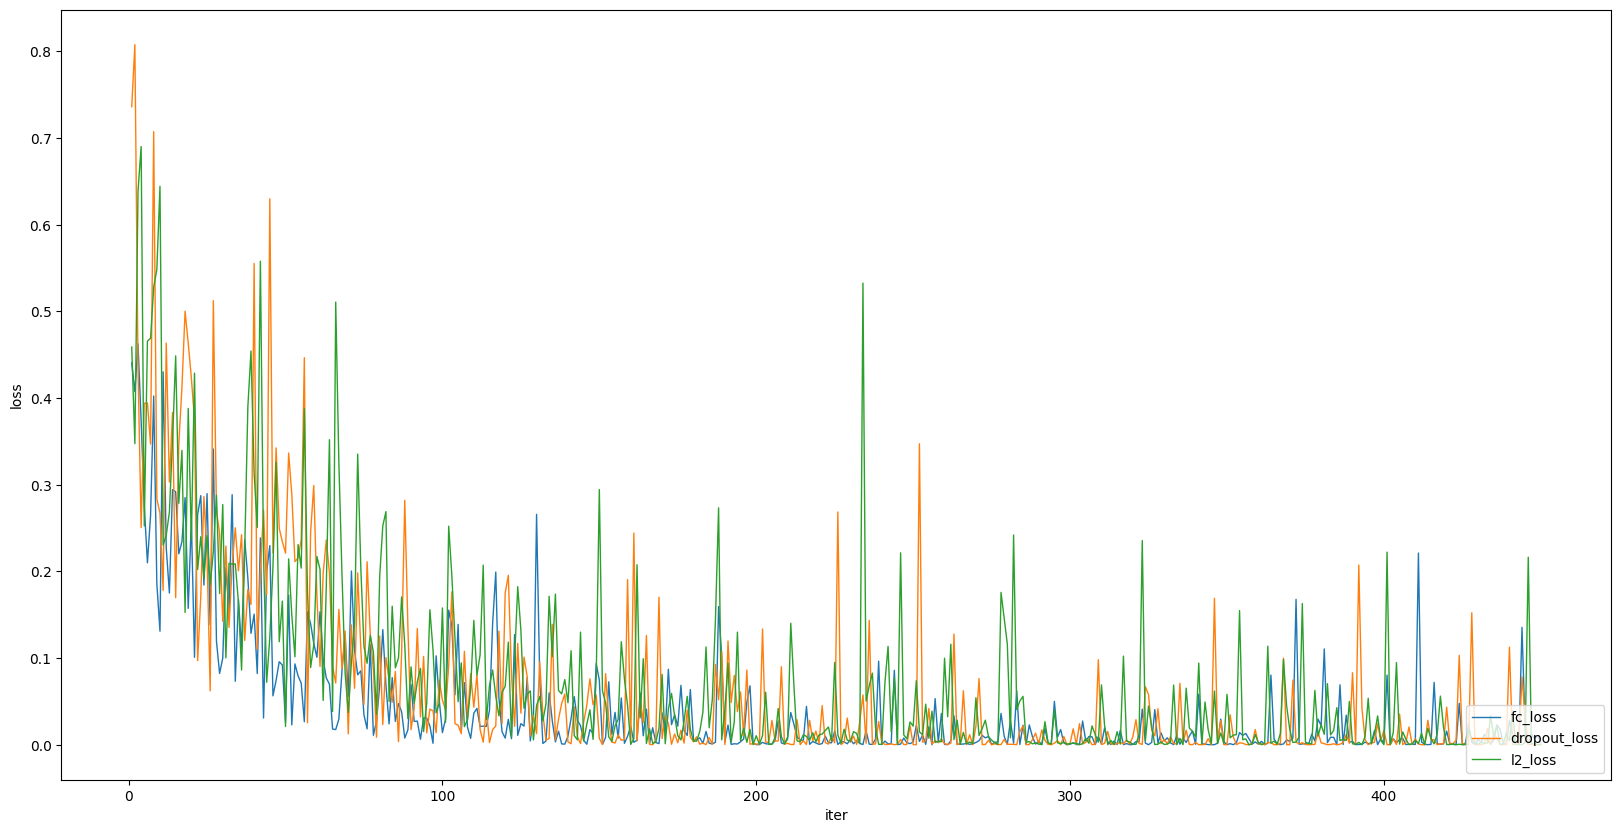

In [41]:
drawCurves([fc_loss,dropout_loss,l2_loss], ['fc_loss','dropout_loss','l2_loss'])

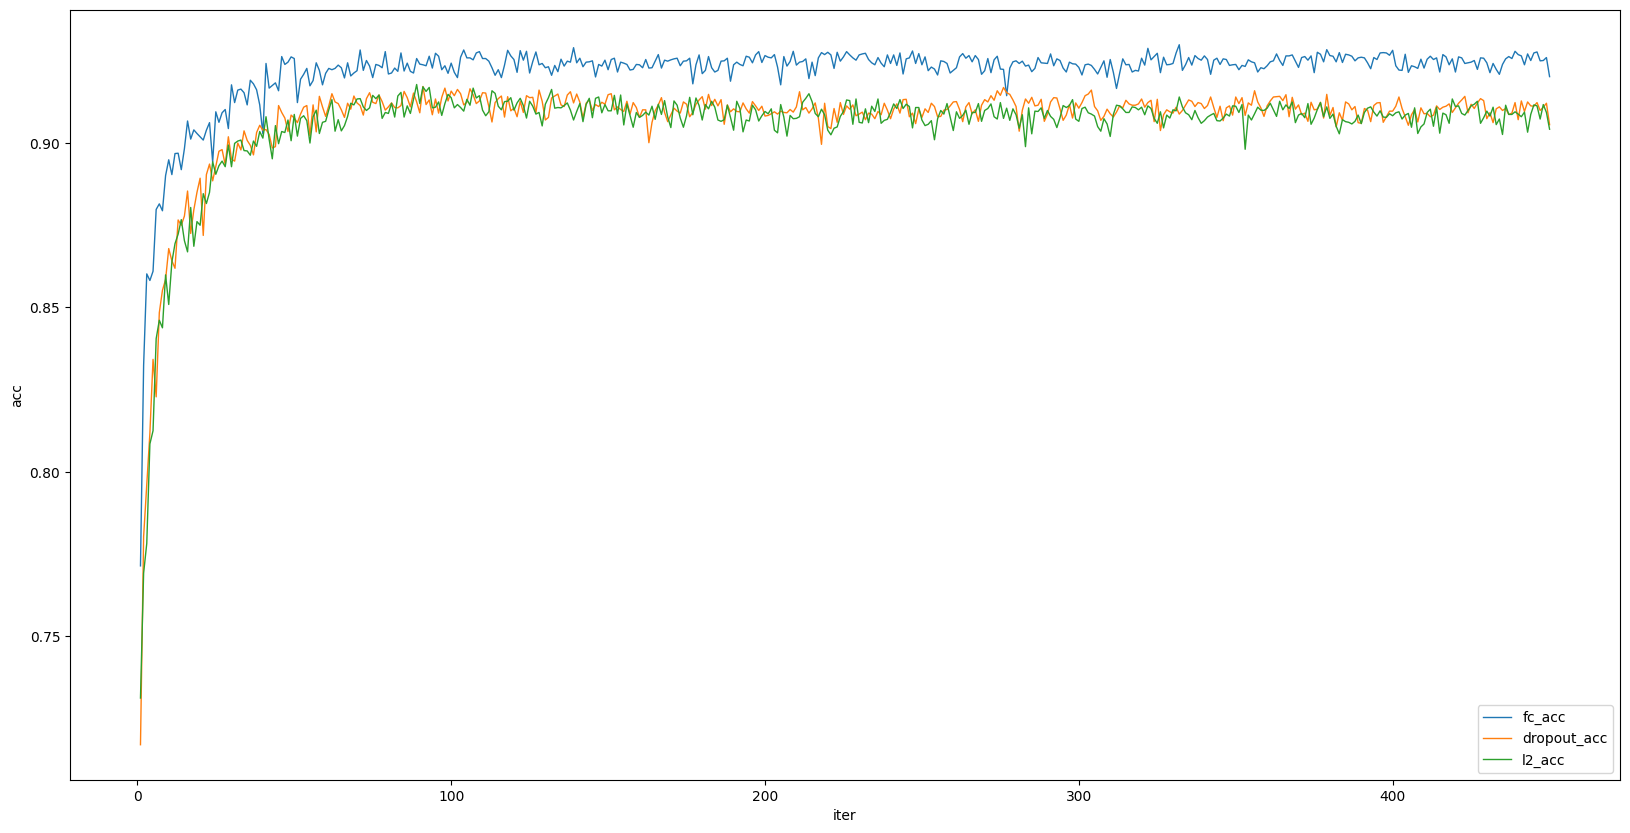

In [38]:
drawCurves([fc_acc,dropout_acc,l2_acc], ['fc_acc','dropout_acc','l2_acc'])

## 实验结果与分析（20'）

### 任务一（5'）

运行baseline，并**将不带正则化的结果（acc）贴至实验报告中**。（若任务二也完成，可与任务二的实验结果合并粘贴）


### 任务二（10'）

补充实验内容中的代码，实现dropout、l2的正则项的添加，**将修改后的网络结构和训练模块代码块（上方已标记）、相应模型的训练结果贴至实验报告中**

|  model              |      acc                |
| ----------------    | ----------------------- |
| 无正则化             |  0.00     |
| dropout             | 0.00      |
|  l2                 | 0.00      |


### 任务三（5'）

请在下方利用drawCurves实现对loss_train和acc_test曲线的绘制，并**将结果记录至实验报告中**，结合各模型的acc，试着**对结果进行分析**。

![loss_train示例图](http://picbed.rubbishman.xyz/202312191957338.png)